# Evaluate and visualise temporal MLP models


## Data loading function




In [124]:
# prompt: Load data from mounted google drive In colab folder

import pandas as pd
import os

def load_data(data_path):
    # Load your data using pandas or any other suitable library
    import pandas as pd
    try:
      df = pd.read_csv(data_path, index_col=False)
      print("Data loaded successfully.")
      if 'UniqueID' in df.columns:
        df = df.drop('UniqueID', axis=1)
      if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
      df['TiltDistToStart'] = df['TiltStartPosition'] - df['TiltPosition']
      df['PanDistToStart'] = df['PanStartPosition'] - df['PanPosition']
      # Now you can work with the DataFrame 'df'
    except FileNotFoundError:
      print(f"Error: File not found at {data_path}")
    except Exception as e:
      print(f"An error occurred: {e}")

    return df

## Model and training parameters

In [125]:

all_data_path = './all_data_position_control_raw_20250901.csv'
targets = ['TiltCurrent', 'PanCurrent']
features_to_exclude = ['TiltCurrent', 'PanCurrent', 'TiltEffectiveCurrent', 'PanEffectiveCurrent']
#features_tilt = ['GyroX', 'GyroY', 'GyroZ', 'AccelX', 'AccelY', 'AccelZ', 'AngleX','AngleY', 'AngleZ', 'TiltPosition', 'TiltDistToGoal', 'TiltDistToStart']
#features_pan = ['GyroX', 'GyroY', 'GyroZ', 'AccelX', 'AccelY', 'AccelZ','AngleX','AngleY', 'AngleZ', 'PanPosition', 'PanDistToGoal', 'PanDistToStart', 'TiltPosition']
features = ['GyroX', 'GyroY', 'GyroZ', 'AccelX', 'AccelY', 'AccelZ','AngleX','AngleY', 'AngleZ', 'TiltPosition', 'TiltDistToGoal', 'TiltDistToStart', 'PanPosition', 'PanDistToGoal', 'PanDistToStart']
features_no_IMU = ['TiltPosition', 'TiltDistToGoal', 'TiltDistToStart', 'PanPosition', 'PanDistToGoal', 'PanDistToStart']
combined=True


In [126]:
data = load_data(all_data_path)
data.shape

Data loaded successfully.


(39394, 23)

## Splitting and scaling data

In [127]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

if combined:
    print("Processing data for combined model...")

    # Features are the same for predicting both TiltCurrent and PanCurrent
    # The target variables are TiltCurrent and PanCurrent
    X = data[features]
    y = data[['TiltCurrent', 'PanCurrent']] # Target variables

    # Split the data into training and testing sets
    X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


    # Standardize the combined data using the mean and standard deviation of the training data
    X_combined_train_mean = X_combined_train.mean()
    X_combined_train_std = X_combined_train.std()
    X_combined_train_scaled = (X_combined_train - X_combined_train_mean) / X_combined_train_std
    X_combined_test_scaled = (X_combined_test - X_combined_train_mean) / X_combined_train_std

    # Calculate mean and std for tilt and pan targets from the combined training data
    y_tilt_train_mean = y_combined_train['TiltCurrent'].mean()
    y_tilt_train_std = y_combined_train['TiltCurrent'].std()
    y_pan_train_mean = y_combined_train['PanCurrent'].mean()
    y_pan_train_std = y_combined_train['PanCurrent'].std()

    y_combined_train_mean_combined = y_combined_train.mean() # Renamed to avoid conflict
    y_combined_train_std_combined = y_combined_train.std()   # Renamed to avoid conflict
    y_combined_train_scaled = (y_combined_train - y_combined_train_mean_combined) / y_combined_train_std_combined
    y_combined_test_scaled = (y_combined_test - y_combined_train_mean_combined) / y_combined_train_std_combined


    print("Combined Data Scaled Shapes:")
    print("X_combined_train_scaled:", X_combined_train_scaled.shape)
    print("X_combined_test_scaled:", X_combined_test_scaled.shape)
    print("y_combined_train_scaled:", y_combined_train_scaled.shape)
    print("y_combined_test_scaled:", y_combined_test_scaled.shape)
    print("Features: " + str(features))


else:
    print("Processing data for separate tilt and pan models...")
    # Split tilt data
    X_tilt = data[features]
    y_tilt = data[['TiltCurrent']]  # Target variable # Use double brackets to select multiple columns
    X_tilt_train, X_tilt_test, y_tilt_train, y_tilt_test = train_test_split(X_tilt, y_tilt, test_size=0.2, random_state=42, shuffle=False) # Adjust test_size as needed

    # Split pan data
    X_pan = data[features]
    y_pan = data[['PanCurrent']]  # Target variable # Use double brackets to select multiple columns
    X_pan_train, X_pan_test, y_pan_train, y_pan_test = train_test_split(X_pan, y_pan, test_size=0.2, random_state=42, shuffle=False) # Adjust test_size as needed

    num_inputs = X_tilt.shape[1]

    print("Tilt Data Shapes:")
    print("X_tilt_train:", X_tilt_train.shape)
    print("X_tilt_test:", X_tilt_test.shape)
    print("y_tilt_train:", y_tilt_train.shape)
    print("y_tilt_test:", y_tilt_test.shape)

    print("\nPan Data Shapes:")
    print("X_pan_train:", X_pan_train.shape)
    print("X_pan_test:", X_pan_test.shape)
    print("y_pan_train:", y_pan_train.shape)
    print("y_pan_test:", y_pan_test.shape)


    # Standardize the data using the mean and standard deviation of the training data
    X_tilt_train_mean = X_tilt_train.mean()
    X_tilt_train_std = X_tilt_train.std()
    X_tilt_train_scaled = (X_tilt_train - X_tilt_train_mean) / X_tilt_train_std
    X_tilt_test_scaled = (X_tilt_test - X_tilt_train_mean) / X_tilt_train_std

    y_tilt_train_mean = y_tilt_train.mean()
    y_tilt_train_std = y_tilt_train.std()
    y_tilt_train_scaled = (y_tilt_train - y_tilt_train_mean) / y_tilt_train_std
    y_tilt_test_scaled = (y_tilt_test - y_tilt_train_mean) / y_tilt_train_std


    X_pan_train_mean = X_pan_train.mean()
    X_pan_train_std = X_pan_train.std()
    X_pan_train_scaled = (X_pan_train - X_pan_train_mean) / X_pan_train_std
    X_pan_test_scaled = (X_pan_test - X_pan_train_mean) / X_pan_train_std


    y_pan_train_mean = y_pan_train.mean()
    y_pan_train_std = y_pan_train.std()
    y_pan_train_scaled = (y_pan_train - y_pan_train_mean) / y_pan_train_std
    y_pan_test_scaled = (y_pan_test - y_pan_train_mean) / y_pan_train_std

    print("Tilt Data Scaled Shapes:")
    print("X_tilt_train_scaled:", X_tilt_train_scaled.shape)
    print("X_tilt_test_scaled:", X_tilt_test_scaled.shape)
    print("y_tilt_train_scaled:", y_tilt_train_scaled.shape)
    y_tilt_test_scaled = y_tilt_test_scaled.astype(np.float32) # Ensure correct dtype
    print("y_tilt_test_scaled:", y_tilt_test_scaled.shape)

    print("\nPan Data Scaled Shapes:")
    print("X_pan_train_scaled:", X_pan_train_scaled.shape)
    print("X_pan_test_scaled:", X_pan_test_scaled.shape)
    print("y_pan_train_scaled:", y_pan_train_scaled.shape)
    y_pan_test_scaled = y_pan_test_scaled.astype(np.float32) # Ensure correct dtype
    print("y_pan_test_scaled:", y_pan_test_scaled.shape)

Processing data for combined model...
Combined Data Scaled Shapes:
X_combined_train_scaled: (31515, 15)
X_combined_test_scaled: (7879, 15)
y_combined_train_scaled: (31515, 2)
y_combined_test_scaled: (7879, 2)
Features: ['GyroX', 'GyroY', 'GyroZ', 'AccelX', 'AccelY', 'AccelZ', 'AngleX', 'AngleY', 'AngleZ', 'TiltPosition', 'TiltDistToGoal', 'TiltDistToStart', 'PanPosition', 'PanDistToGoal', 'PanDistToStart']


In [128]:
def combine_mean_std(mean_series, std_series):
  """Combines mean and std Series into a dictionary with mean and std keys."""
  combined_dict = {}
  # Ensure mean_series and std_series are pandas Series
  mean_series = pd.Series(mean_series)
  std_series = pd.Series(std_series)

  for col in mean_series.index:
    combined_dict[col] = {'mean': float(mean_series[col]), 'std': float(std_series[col])}
  return combined_dict

import json
import pandas as pd # Import pandas here
import numpy as np # Import numpy

# Ensure y_tilt_train_mean/std and y_pan_train_mean/std are Series even if they were single values
# This is now handled in the combine_mean_std function by converting to Series


#save mean and stds dict
if combined:
  # For combined model, we already have combined mean and std
  # Use y_combined_train_mean_combined and y_combined_train_std_combined
  mean_std = combine_mean_std(y_combined_train_mean_combined, y_combined_train_std_combined)


else:
  # Combine means and stds for tilt data
  tilt_mean_std = combine_mean_std(pd.concat([X_tilt_train_mean, pd.Series([y_tilt_train_mean])]), pd.concat([X_tilt_train_std, pd.Series([y_tilt_train_std])]))
  pan_mean_std = combine_mean_std(pd.concat([X_pan_train_mean, pd.Series([y_pan_train_mean])]), pd.concat([X_pan_train_std, pd.Series([y_pan_train_std])]))


## Sequence data function

In [129]:
import pandas as pd
import numpy as np

def create_sequences(data_array, sequence_length=10):
    """
    Create sequences of consecutive rows for neural network input from a NumPy array.

    Args:
        data_array (np.ndarray): The input NumPy array.
        sequence_length (int): The number of previous time steps to include in each sequence.

    Returns:
        np.ndarray: Time-stepped feature data (samples, time_step, features).
    """
    sequences = []

    for i in range(len(data_array) - sequence_length + 1):
        # Get sequence of 10 rows
        sequence = data_array[i:i + sequence_length]
        sequences.append(sequence)

    return np.array(sequences)



In [130]:
from re import I
# prompt: apply time_step to combined data if model_name is combined, otherwise apply to tilt and pan data separately

def sequence_data(X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test, time_step):
    """
    Creates time-stepped sequences for features and aligns targets.
    """
    print("Applying time-stepping to combined data...")

    # Create sequences for features
    X_train_ts = create_sequences(X_scaled_train.values, sequence_length=time_step)
    X_test_ts = create_sequences(X_scaled_test.values, sequence_length=time_step)

    # Align targets with the last step of each sequence.
    # The number of sequences will be `len(original_data) - time_step + 1`.
    # The corresponding targets are the values from the original y_scaled_data
    # starting from the `time_step`-th row (index `time_step-1`).
    y_train_ts_targets = y_scaled_train.values[time_step-1:]
    y_test_ts_targets = y_scaled_test.values[time_step-1:]

    print("Time-stepped Data Shapes:")
    print("X_train_ts:", X_train_ts.shape)
    print("X_test_ts:", X_test_ts.shape)
    print("y_train_ts_targets:", y_train_ts_targets.shape)
    print("y_test_ts_targets:", y_test_ts_targets.shape)

    return X_train_ts, X_test_ts, y_train_ts_targets, y_test_ts_targets


## Custom weighted loss



In [131]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU, Flatten, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.losses import Huber
import keras.backend as K
import json
import os
import sys
import pickle
import pandas as pd # Import pandas for binning
import numpy as np # Import numpy

@tf.function
def weighted_mse_high_current(y_true, y_pred):
    threshold = 1.8 # Adjust based on your scaled data's range
    is_high_magnitude = tf.cast(tf.abs(y_true) > threshold, tf.float32)
    # Give e.g., 5x more weight to high magnitude samples
    weights = 1.0 + is_high_magnitude * 4.0
    # Use tf.reduce_mean instead of K.mean
    return tf.reduce_mean(weights * tf.square(y_pred - y_true), axis=-1)

# Refined weighted_mse loss function using spike analysis data
@tf.function
def weighted_mse_refined(y_true, y_pred, X_batch, avg_spike_data, features_tilt, features_pan, time_step):
    """Custom Mean Squared Error loss with weighting based on spike analysis."""
    # Ensure X_batch is a TensorFlow tensor
    X_batch = tf.cast(X_batch, tf.float32)

    # Extract relevant features from the last time step of the batch
    # We need the original scale features for binning
    # Assuming X_batch contains scaled features and needs inverse transformation
    # This part needs to be carefully aligned with how your data is structured and scaled

    # For demonstration purposes, let's assume X_batch is already in the correct shape
    # (batch_size, time_step, features) and we need to get the features for the last time step
    last_time_step_features = X_batch[:, -1, :] # Get features from the last time step

    # This is a simplified approach. You would need to map these scaled features back to original scale
    # using your mean/std values if your bin edges are based on original scale.
    # For now, let's assume you have a way to get the features in the scale used for binning.

    # Example: Get TiltPosition and PanPosition from the batch (indices will depend on your feature order)
    # You'll need to adjust indices based on the order of features in your X_combined_train_scaled/X_tilt/X_pan
    tilt_pos_idx = features_tilt.index('TiltPosition') if 'TiltPosition' in features_tilt else None
    pan_pos_idx = features_pan.index('PanPosition') if 'PanPosition' in features_pan else None
    tilt_dist_start_idx = features_tilt.index('TiltDistToStart') if 'TiltDistToStart' in features_tilt else None
    pan_dist_start_idx = features_pan.index('PanDistToStart') if 'PanDistToStart' in features_pan else None
    tilt_dist_goal_idx = features_tilt.index('TiltDistToGoal') if 'TiltDistToGoal' in features_tilt else None
    pan_dist_goal_idx = features_pan.index('PanDistToGoal') if 'PanDistToGoal' in features_pan else None


    # Determine weights based on average spike data
    weights = tf.ones_like(y_true) # Start with weights of 1

    # This part is complex to implement directly in a @tf.function due to dynamic binning lookup.
    # A common approach is to pre-calculate weights for your training data based on their bins
    # and pass these weights during model.fit using the `sample_weight` argument.
    # Or, create a lookup structure that is compatible with TensorFlow operations.

    # For demonstration, let's use a simplified weighting based on a threshold on the target
    # You can replace this with your bin-based weighting logic
    threshold = 1.8 # Example threshold on scaled target
    is_high_magnitude = tf.cast(tf.abs(y_true) > threshold, tf.float32)
    weights = 1.0 + is_high_magnitude * 4.0 # Example weighting


    # Apply weights to the squared error
    # Ensure weights shape matches the squared error shape
    weighted_squared_error = weights * tf.square(y_pred - y_true)

    return tf.reduce_mean(weighted_squared_error, axis=-1)
    # Helper function to calculate sample weights based on spike analysis
def calculate_sample_weights(X_data, y_data, avg_spike_data, features_tilt, features_pan, time_step, pan_pos_bins_edges, tilt_pos_bins_edges, pan_dist_start_bins_edges, tilt_dist_start_bins_edges, pan_dist_goal_bins_edges, tilt_dist_goal_bins_edges):
    """
    Calculates sample weights based on average spike data for each sample.

    Args:
        X_data (np.ndarray): The input feature data (samples, time_step, features).
        y_data (np.ndarray): The target data (samples, targets).
        avg_spike_data (dict): Dictionary containing average spike data by bins.
        features_tilt (list): List of tilt features.
        features_pan (list): List of pan features.
        time_step (int): The time step used for sequences.
        pan_pos_bins_edges (np.ndarray): Edges for pan position bins.
        tilt_pos_bins_edges (np.ndarray): Edges for tilt position bins.
        pan_dist_start_bins_edges (np.ndarray): Edges for pan distance to start bins.
        tilt_dist_start_bins_edges (np.ndarray): Edges for tilt distance to start bins.
        pan_dist_goal_bins_edges (np.ndarray): Edges for pan distance to goal bins.
        tilt_dist_goal_bins_edges (np.ndarray): Edges for tilt distance to goal bins.


    Returns:
        np.ndarray: Array of sample weights.
    """
    # Initialize weights to 1
    weights = np.ones(len(X_data))

    # Get features from the last time step (corresponding to the target)
    last_time_step_features = X_data[:, -1, :]

    # Assuming your features in X_data are in the order defined by features_tilt and features_pan (for combined model)
    # or just features_tilt/features_pan for separate models.
    # You need to map these back to original scale if your bins are based on original scale.
    # This is a placeholder and needs actual inverse scaling if necessary.
    # For demonstration, we'll assume features are in a scale compatible with the bin edges.

    if 'combined' in model_name:
        # Assuming a combined model where features are concatenated
        # Need to adjust indices based on the order of features in X_combined_train_scaled
        try:
            # Ensure 'features' is accessible, assuming it's defined globally or passed
            features_list = features.tolist() if isinstance(features, np.ndarray) else features
            tilt_pos_idx = features_list.index('TiltPosition')
            pan_pos_idx = features_list.index('PanPosition')
            tilt_dist_start_idx = features_list.index('TiltDistToStart')
            pan_dist_start_idx = features_list.index('PanDistToStart')
            tilt_dist_goal_idx = features_list.index('TiltDistToGoal')
            pan_dist_goal_idx = features_list.index('PanDistToGoal')

            tilt_pos_batch = last_time_step_features[:, tilt_pos_idx]
            pan_pos_batch = last_time_step_features[:, pan_pos_idx]
            tilt_dist_start_batch = last_time_step_features[:, tilt_dist_start_idx]
            pan_dist_start_batch = last_time_step_features[:, pan_dist_start_idx]
            tilt_dist_goal_batch = last_time_step_features[:, tilt_dist_goal_idx]
            pan_dist_goal_batch = last_time_step_features[:, pan_dist_goal_idx]

        except ValueError as e:
            print(f"Error finding feature index: {e}. Ensure features list is correctly defined.")
            return weights # Return default weights if features are not found


        # Assign weights based on average spike in corresponding bins
        # This part requires mapping batch values to bins and looking up average spike values.
        # This is non-trivial to implement efficiently in NumPy/TensorFlow without pre-calculated lookups or more advanced indexing.
        # A simplified approach is to iterate or use pandas binning on a temporary DataFrame (less efficient within a training loop)

        # For a practical implementation during training, it's better to pre-calculate weights for your entire training dataset
        # and pass them to model.fit using the `sample_weight` argument.

        # --- Placeholder for actual bin-based weighting logic ---
        # Example: Assign higher weight if absolute true current is high (similar to weighted_mse_high_current but can be combined with bin info)
        threshold = 1.8 # Example threshold on scaled target
        is_high_magnitude_tilt = np.abs(y_data[:, 0]) > threshold
        is_high_magnitude_pan = np.abs(y_data[:, 1]) > threshold
        is_high_magnitude = is_high_magnitude_tilt | is_high_magnitude_pan
        weights[is_high_magnitude] = 5.0 # Example: Assign weight of 5 to high magnitude samples

        # You would replace the above with logic that finds the bin for each sample's features
        # and assigns a weight based on the average spike value in that bin from avg_spike_data.
        # This would likely involve using pd.cut or similar logic.

    else:
        # Assuming separate tilt and pan models
         try:
            tilt_pos_idx = features_tilt.index('TiltPosition')
            tilt_dist_start_idx = features_tilt.index('TiltDistToStart')
            tilt_dist_goal_idx = features_tilt.index('TiltDistToGoal')

            pan_pos_idx = features_pan.index('PanPosition')
            pan_dist_start_idx = features_pan.index('PanDistToStart')
            pan_dist_goal_idx = features_pan.index('PanDistToGoal')

            tilt_pos_batch = last_time_step_features[:, tilt_pos_idx]
            tilt_dist_start_batch = last_time_step_features[:, tilt_dist_start_idx]
            tilt_dist_goal_batch = last_time_step_features[:, tilt_dist_goal_idx]

            pan_pos_batch = last_time_step_features[:, pan_pos_idx]
            pan_dist_start_batch = last_time_step_features[:, pan_dist_start_idx]
            pan_dist_goal_batch = last_time_step_features[:, pan_dist_goal_idx]


         except ValueError as e:
            print(f"Error finding feature index: {e}. Ensure features list is correctly defined.")
            return weights # Return default weights if features are not found







## Load models

In [137]:
from keras.models import load_model

TS_0_no_IMU = load_model('./temporal_mlp_TimeSteps0_no_IMU.keras')
TS_1_no_IMU = load_model('./temporal_mlp_TimeSteps1_no_IMU.keras')
TS_3_no_IMU = load_model('./temporal_mlp_TimeSteps3_no_IMU.keras')
TS_5_no_IMU = load_model('./temporal_mlp_TimeSteps5_no_IMU.keras')
TS_10_no_IMU = load_model('./temporal_mlp_TimeSteps10_no_IMU.keras')
TS_15_no_IMU = load_model('./temporal_mlp_TimeSteps15_no_IMU.keras')

TS_0 = load_model('./temporal_mlp_TimeSteps0.keras')
TS_1 = load_model('./temporal_mlp_TimeSteps1.keras')
TS_3 = load_model('./temporal_mlp_TimeSteps3.keras')
TS_5 = load_model('./temporal_mlp_TimeSteps5.keras')
TS_10 = load_model('./temporal_mlp_TimeSteps10.keras')
TS_15 = load_model('./temporal_mlp_TimeSteps15.keras')

models_lst = [TS_0_no_IMU, TS_1_no_IMU, TS_3_no_IMU, TS_5_no_IMU, TS_10_no_IMU, TS_0, TS_1, TS_3, TS_5, TS_10, TS_15]

In [133]:
mean_std = pd.read_json('./scalars_features/mean_std.json')


In [135]:
import matplotlib.pyplot as plt

def prediction_errors_distance_plots(predictions, y_true, X_test, mean_std, features, timestep, IMU_model=False):
    """
    Plots prediction errors against distance to start and goal for tilt and pan.

    Args:
        predictions (np.ndarray): Model predictions.
        y_true (np.ndarray): True target values.
        X_combined_test (pd.DataFrame): Original test features (unscaled).
        mean_std (pd.DataFrame): DataFrame containing mean and std for unstandardization.
        features (list): List of feature names.
        timestep (int): The time step used in the model.
    """

    # Unstandardise test features
    X_test_unscaled = X_test[timestep-1:] * mean_std.loc['std', features].values + mean_std.loc['mean', features].values

    prediction_errors = predictions - y_true
    # Extract distance to start and goal columns
    tilt_dist_to_start = X_test_unscaled['TiltDistToGoal']
    tilt_dist_to_goal = X_test_unscaled['TiltDistToGoal']
    pan_dist_to_start = X_test_unscaled['PanDistToStart']
    pan_dist_to_goal = X_test_unscaled['PanDistToGoal']

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Tilt predictions vs TiltDistToStart
    axs[0, 0].scatter(tilt_dist_to_start, prediction_errors[:, 0], alpha=0.5)
    axs[0, 0].set_xlabel('TiltDistToStart')
    axs[0, 0].set_ylabel('Predicted TiltCurrent')
    axs[0, 0].set_title('Predicted TiltCurrent vs TiltDistToStart')

    # Tilt predictions vs TiltDistToGoal
    axs[0, 1].scatter(tilt_dist_to_goal, prediction_errors[:, 0], alpha=0.5)
    axs[0, 1].set_xlabel('TiltDistToGoal')
    axs[0, 1].set_ylabel('Predicted TiltCurrent')
    axs[0, 1].set_title('Predicted TiltCurrent vs TiltDistToGoal')

    # Pan predictions vs PanDistToStart
    axs[1, 0].scatter(pan_dist_to_start, prediction_errors[:, 1], alpha=0.5)
    axs[1, 0].set_xlabel('PanDistToStart')
    axs[1, 0].set_ylabel('Predicted PanCurrent')
    axs[1, 0].set_title('Predicted PanCurrent vs PanDistToStart')

    # Pan predictions vs PanDistToGoal
    axs[1, 1].scatter(pan_dist_to_goal, prediction_errors[:, 1], alpha=0.5)
    axs[1, 1].set_xlabel('PanDistToGoal')
    axs[1, 1].set_ylabel('Predicted PanCurrent')
    axs[1, 1].set_title('Predicted PanCurrent vs PanDistToGoal')

    IMU_model_str = "with IMU" if IMU_model else "without IMU"

    plt.suptitle(f'Prediction Errors vs Distance Plots for Time Step {timestep} {IMU_model_str}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'./plots/prediction_errors_distance_plots_timestep{timestep}_{IMU_model_str}.png')
   
    



Evaluating model: temporal_mlp_TimeSteps0_no_IMU with time step 0 using features: ['TiltPosition', 'TiltDistToGoal', 'TiltDistToStart', 'PanPosition', 'PanDistToGoal', 'PanDistToStart']
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


InvalidIndexError: (slice(None, None, None), 0)

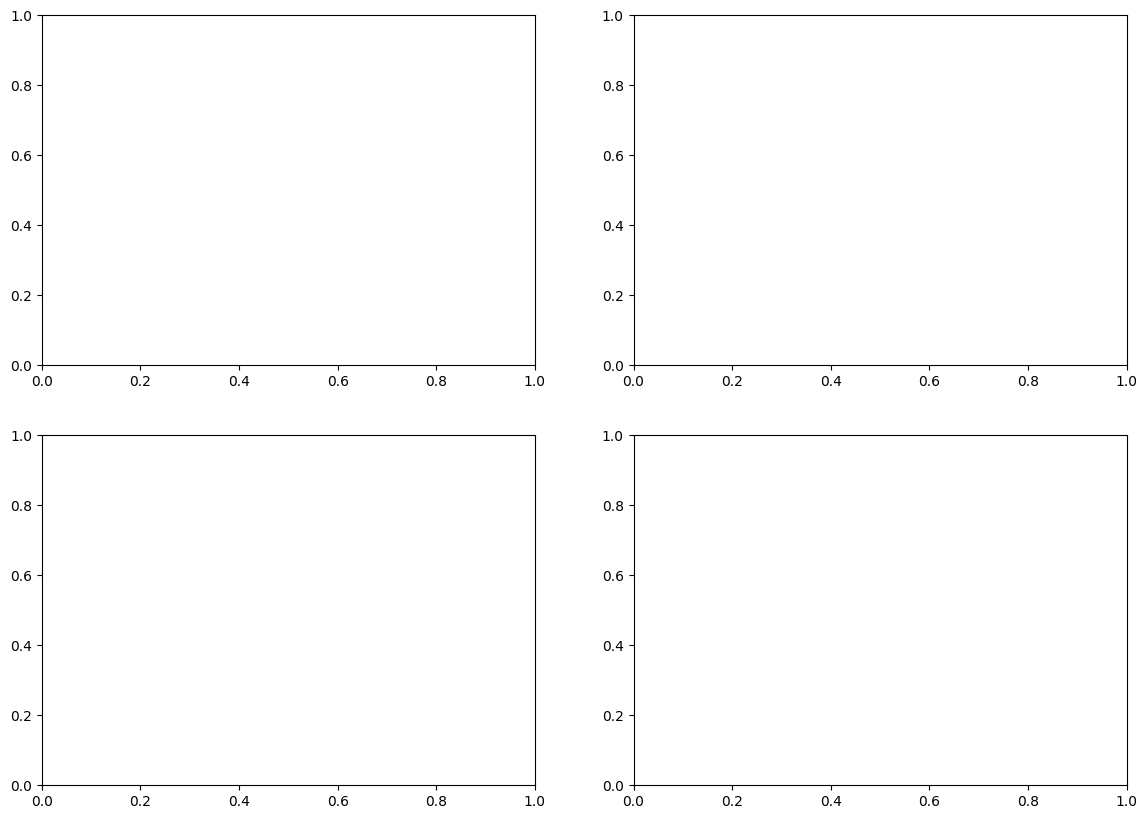

In [139]:
import tensorflow as tf
metrics = {}


for model in models_lst:
    timestep = int(model.name.split('TimeSteps')[1].split('_')[0])
    features_in_use = features_no_IMU if 'no_IMU' in model.name else features
    IMU_model = True if 'no_IMU' not in model.name else False
    print(f"Evaluating model: {model.name} with time step {timestep} using features: {features_in_use}")

    if timestep >0:
        X_train_ts, X_test_ts, y_train_ts, y_test_ts = sequence_data(X_combined_train_scaled[features_in_use], X_combined_test_scaled[features_in_use], y_combined_train_scaled, y_combined_test_scaled, time_step=timestep)
    else:
        X_train_ts, X_test_ts, y_train_ts, y_test_ts= X_combined_train_scaled[features_in_use], X_combined_test_scaled[features_in_use], y_combined_train_scaled, y_combined_test_scaled

    predictions_scaled = model.predict(X_test_ts)
    predictions = predictions_scaled * mean_std.loc['std', targets].values + mean_std.loc['mean', targets].values
    X_test = X_combined_test[features_in_use]
    y_true = y_test_ts *  mean_std.loc['std', targets].values + mean_std.loc['mean', targets].values
    prediction_errors_distance_plots(predictions, y_true, X_test, mean_std, features_in_use, timestep, IMU_model=IMU_model)
    print("Pltos saved in ./plots/ folder")

   
    #using evaluate
    loss, mse = model.evaluate(X_test_ts, y_test_ts, verbose=0)
    print(f"Model: {model.name} - Loss: {loss}, MSE: {mse}")

    metrics[model.name] = {
        'Loss': float(loss),
        'MSE': float(mse)
    }




In [145]:
X_combined_test.shape

(7879, 15)

In [147]:
for model in models_lst:
    timestep = int(model.name.split('TimeSteps')[1].split('_')[0])
    features_in_use = features_no_IMU if 'no_IMU' in model.name else features
    IMU_model = True if 'no_IMU' not in model.name else False
    print(f"Evaluating model: {model.name} with time step {timestep} using features: {features_in_use}")
     #using evaluate
    if timestep >0:
        X_train_ts, X_test_ts, y_train_ts, y_test_ts = sequence_data(X_combined_train_scaled[features_in_use], X_combined_test_scaled[features_in_use], y_combined_train_scaled, y_combined_test_scaled, time_step=timestep)
    else:
        X_train_ts, X_test_ts, y_train_ts, y_test_ts= X_combined_train_scaled[features_in_use], X_combined_test_scaled[features_in_use], y_combined_train_scaled, y_combined_test_scaled

    loss, mse = model.evaluate(X_test_ts, y_test_ts, verbose=0)
    print(f"Model: {model.name} - Loss: {loss}, MSE: {mse}")

    metrics[model.name] = {
        'Loss': float(loss),
        'MSE': float(mse)
    }

Evaluating model: temporal_mlp_TimeSteps0_no_IMU with time step 0 using features: ['TiltPosition', 'TiltDistToGoal', 'TiltDistToStart', 'PanPosition', 'PanDistToGoal', 'PanDistToStart']
Model: temporal_mlp_TimeSteps0_no_IMU - Loss: 0.08259864151477814, MSE: 0.2566351294517517
Evaluating model: temporal_mlp_TimeSteps1_no_IMU with time step 1 using features: ['TiltPosition', 'TiltDistToGoal', 'TiltDistToStart', 'PanPosition', 'PanDistToGoal', 'PanDistToStart']
Applying time-stepping to combined data...
Time-stepped Data Shapes:
X_train_ts: (31515, 1, 6)
X_test_ts: (7879, 1, 6)
y_train_ts_targets: (31515, 2)
y_test_ts_targets: (7879, 2)


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

In [140]:
metrics_df = pd.DataFrame(metrics).T

# Separate IMU and no_IMU models
imu_models = metrics_df[~metrics_df.index.str.contains('no_IMU')]
no_imu_models = metrics_df[metrics_df.index.str.contains('no_IMU')]


# Extract time steps from model names
def extract_timestep(model_name):
    return int(model_name.split('_TimeSteps')[1].split('_')[0])

# Create DataFrames with time steps as index
imu_df = pd.DataFrame(index=sorted(imu_models.index.map(extract_timestep).unique()))
no_imu_df = pd.DataFrame(index=sorted(no_imu_models.index.map(extract_timestep).unique()))

# Fill in the MSE values
for model_name, row in imu_models.iterrows():
    timestep = extract_timestep(model_name)
    imu_df.loc[timestep, 'MSE'] = row['MSE']

for model_name, row in no_imu_models.iterrows():
    timestep = extract_timestep(model_name)
    no_imu_df.loc[timestep, 'MSE'] = row['MSE']

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(imu_df.index))  # Time steps positions
width = 0.35  # Width of bars

# Plot bars
bars1 = ax.bar(x - width/2, imu_df['MSE'], width, label='With IMU data', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, no_imu_df['MSE'], width, label='No IMU data', alpha=0.8, color='lightcoral')

# Customize the plot
ax.set_xlabel('Time Steps')
ax.set_ylabel('MSE')
ax.set_title('Temporal MLP Evaluation Metrics: MSE by Time Steps and IMU Usage')
ax.set_xticks(x)
ax.set_xticklabels(imu_df.index)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.savefig('./plots/temporal_mlp_evaluation_metrics_comparison.png')
plt.show()

# Also print a summary table
print("\nSummary Table:")
print("Time Step | With IMU MSE | No IMU MSE")
print("-" * 50)
for ts in sorted(set(imu_df.index) | set(no_imu_df.index)):
    imu_mse = imu_df.loc[ts, 'MSE'] if ts in imu_df.index else 'N/A'
    no_imu_mse = no_imu_df.loc[ts, 'MSE'] if ts in no_imu_df.index else 'N/A'
    print(f"{ts:9} | {imu_mse:12} | {no_imu_mse}")

AttributeError: Can only use .str accessor with string values!

In [ ]:
import pickle
import os

def get_epochs_from_history(model_name):
    """
    Load training history from pickle file and extract number of epochs.
    
    Args:
        model_name (str): Name of the model (without extension)
    
    Returns:
        int: Number of epochs trained, or None if file not found
    """
    history_file = f"./history/history_{model_name}.pkl"
    
    if os.path.exists(history_file):
        try:
            with open(history_file, 'rb') as f:
                history = pickle.load(f)
            
            # The history object typically has a 'history' attribute with loss/metrics per epoch
            if hasattr(history, 'history'):
                epochs = len(history.history['loss'])
            elif isinstance(history, dict) and 'loss' in history:
                epochs = len(history['loss'])
            else:
                epochs = len(history) if isinstance(history, list) else None
                
            return epochs
        except Exception as e:
            print(f"Error loading history for {model_name}: {e}")
            return None
    else:
        print(f"History file not found: {history_file}")
        return None

# Get epochs for each model
model_epochs = {}
for model in models_lst:
    model_name = model.name
    epochs = get_epochs_from_history(model_name)
    model_epochs[model_name] = epochs
    print(f"{model_name}: {epochs} epochs")

# Add epochs to metrics
for model_name in metrics:
    if model_name in model_epochs:
        metrics[model_name]['Epochs'] = model_epochs[model_name]

temporal_mlp_TimeSteps1_no_IMU: 135 epochs
temporal_mlp_TimeSteps3_no_IMU: 107 epochs
temporal_mlp_TimeSteps5_no_IMU: 142 epochs
temporal_mlp_TimeSteps10_no_IMU: 108 epochs
temporal_mlp_TimeSteps1: 148 epochs
temporal_mlp_TimeSteps3: 137 epochs
temporal_mlp_TimeSteps5: 117 epochs
temporal_mlp_TimeSteps10: 113 epochs
temporal_mlp_TimeSteps15: 155 epochs



Detailed Summary Table:
Model Name | Time Step | IMU | MSE | Epochs
------------------------------------------------------------
temporal_mlp_TimeSteps1_no_IMU |         1 | No  |  0.2707 | 135.0
temporal_mlp_TimeSteps3_no_IMU |         3 | No  |  0.1731 | 107.0
temporal_mlp_TimeSteps5_no_IMU |         5 | No  |  0.1654 | 142.0
temporal_mlp_TimeSteps10_no_IMU |        10 | No  |  0.1822 | 108.0
temporal_mlp_TimeSteps1   |         1 | Yes |  0.1758 | 148.0
temporal_mlp_TimeSteps3   |         3 | Yes |  0.1511 | 137.0
temporal_mlp_TimeSteps5   |         5 | Yes |  0.1545 | 117.0
temporal_mlp_TimeSteps10  |        10 | Yes |  0.1601 | 113.0
temporal_mlp_TimeSteps15  |        15 | Yes |  0.1622 | 155.0


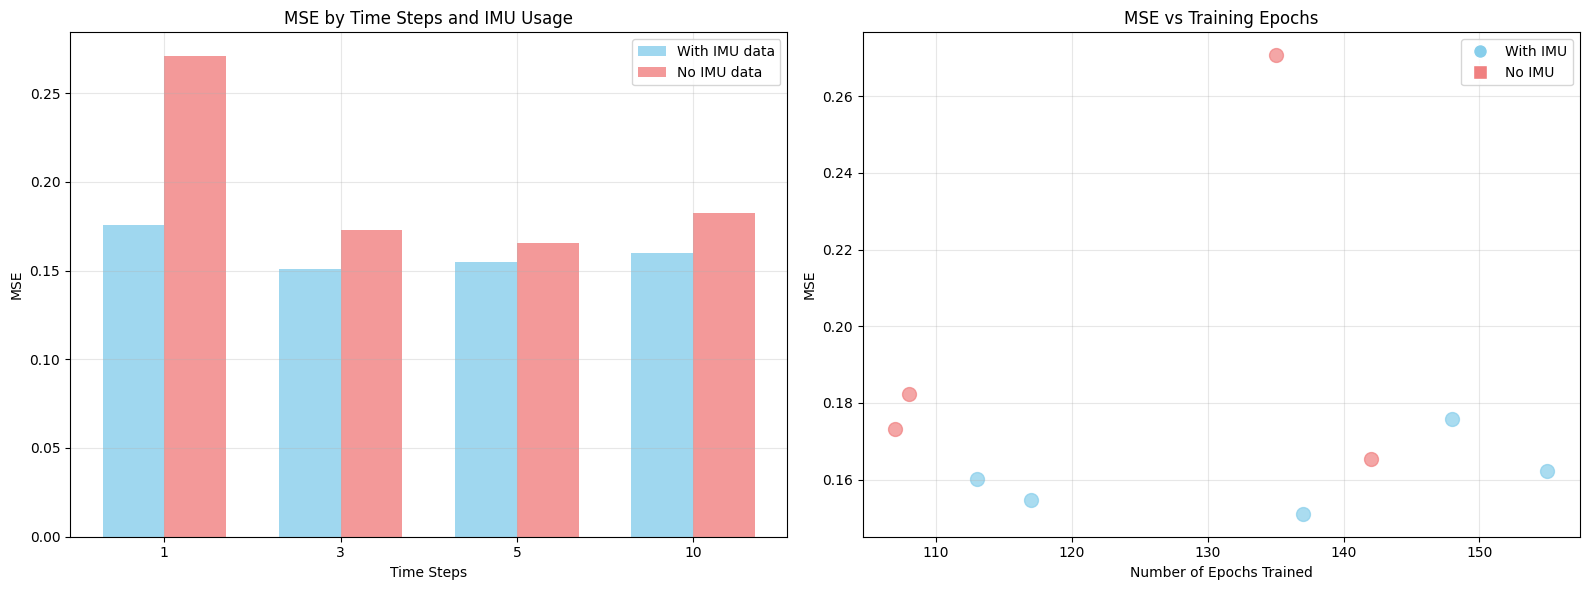

In [ ]:
# Create an updated metrics DataFrame with epochs
metrics_with_epochs_df = pd.DataFrame(metrics).T

# Print detailed summary table including epochs
print("\nDetailed Summary Table:")
print("Model Name | Time Step | IMU | MSE | Epochs")
print("-" * 60)
for model_name, row in metrics_with_epochs_df.iterrows():
    timestep = int(model_name.split('TimeSteps')[1].split('_')[0])
    has_imu = "No" if 'no_IMU' in model_name else "Yes"
    mse = row['MSE']
    epochs = row.get('Epochs', 'N/A')
    print(f"{model_name:<25} | {timestep:9} | {has_imu:3} | {mse:7.4f} | {epochs}")

# Create a plot showing MSE vs Epochs for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: MSE vs Time Steps (existing plot)
imu_models_updated = metrics_with_epochs_df[~metrics_with_epochs_df.index.str.contains('no_IMU')]
no_imu_models_updated = metrics_with_epochs_df[metrics_with_epochs_df.index.str.contains('no_IMU')]

# Remove time step 15 from imu_models for better comparison
imu_models_updated = imu_models_updated[~imu_models_updated.index.str.contains('TimeSteps15')]

# Extract time steps and create comparison DataFrames
imu_df_updated = pd.DataFrame(index=sorted(imu_models_updated.index.map(extract_timestep).unique()))
no_imu_df_updated = pd.DataFrame(index=sorted(no_imu_models_updated.index.map(extract_timestep).unique()))

for model_name, row in imu_models_updated.iterrows():
    timestep = extract_timestep(model_name)
    imu_df_updated.loc[timestep, 'MSE'] = row['MSE']
    imu_df_updated.loc[timestep, 'Epochs'] = row.get('Epochs', 0)

for model_name, row in no_imu_models_updated.iterrows():
    timestep = extract_timestep(model_name)
    no_imu_df_updated.loc[timestep, 'MSE'] = row['MSE']
    no_imu_df_updated.loc[timestep, 'Epochs'] = row.get('Epochs', 0)

# First subplot: MSE vs Time Steps
x = np.arange(len(imu_df_updated.index))
width = 0.35

bars1 = ax1.bar(x - width/2, imu_df_updated['MSE'], width, label='With IMU data', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, no_imu_df_updated['MSE'], width, label='No IMU data', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Time Steps')
ax1.set_ylabel('MSE')
ax1.set_title('MSE by Time Steps and IMU Usage')
ax1.set_xticks(x)
ax1.set_xticklabels(imu_df_updated.index)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second subplot: MSE vs Epochs
# Scatter plot showing relationship between epochs and MSE
for model_name, row in metrics_with_epochs_df.iterrows():
    if row.get('Epochs') is not None:
        color = 'skyblue' if 'no_IMU' not in model_name else 'lightcoral'
        marker = 'o' if 'no_IMU' not in model_name else 's'
        timestep = extract_timestep(model_name)
        ax2.scatter(row['Epochs'], row['MSE'], color=color, s=100, alpha=0.7, 
                   label=f"TS{timestep} {'IMU' if 'no_IMU' not in model_name else 'No IMU'}")

ax2.set_xlabel('Number of Epochs Trained')
ax2.set_ylabel('MSE')
ax2.set_title('MSE vs Training Epochs')
ax2.grid(True, alpha=0.3)

# Create custom legend for the second plot
imu_line = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='With IMU')
no_imu_line = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=10, label='No IMU')
ax2.legend(handles=[imu_line, no_imu_line])

plt.tight_layout()
plt.savefig('./plots/temporal_mlp_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

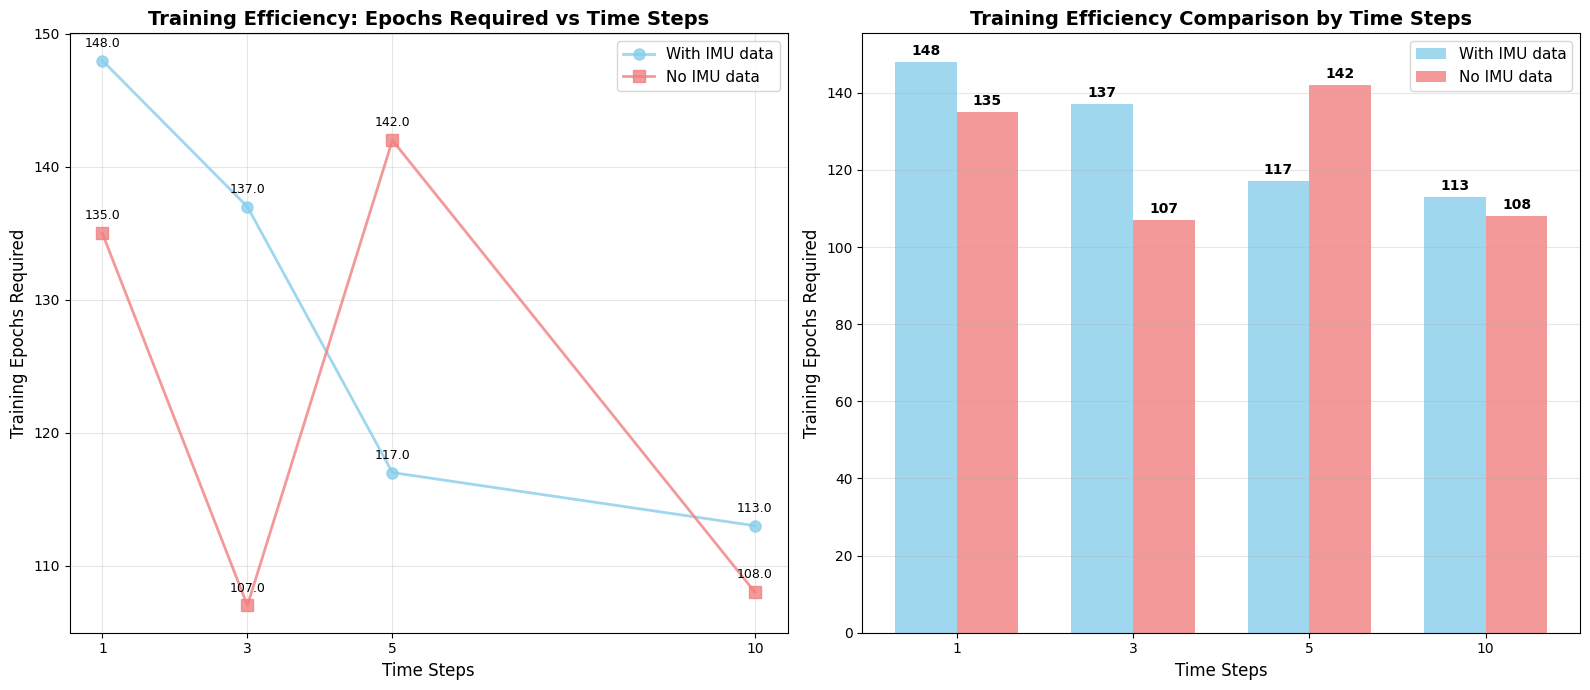


TRAINING EFFICIENCY ANALYSIS

Epochs Required for Convergence:
---------------------------------------------
Time Step | With IMU | No IMU | Difference
---------------------------------------------
        1 |    148.0 |  135.0 |      -13.0
        3 |    137.0 |  107.0 |      -30.0
        5 |    117.0 |  142.0 |      +25.0
       10 |    113.0 |  108.0 |       -5.0

Key Insights:
• Positive difference = No IMU models needed MORE epochs
• Negative difference = No IMU models needed FEWER epochs
• IMU data impact on training convergence varies with time steps


In [ ]:
# Create a dedicated plot showing how IMU data and time steps affected training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Prepare data for plotting
imu_epochs = []
no_imu_epochs = []
imu_timesteps = []
no_imu_timesteps = []

for model_name, row in metrics_with_epochs_df.iterrows():
    if row.get('Epochs') is not None:
        timestep = extract_timestep(model_name)
        epochs = row['Epochs']
        
        if 'no_IMU' in model_name:
            no_imu_epochs.append(epochs)
            no_imu_timesteps.append(timestep)
        else:
            # Skip timestep 15 for better comparison
            if timestep != 15:
                imu_epochs.append(epochs)
                imu_timesteps.append(timestep)

# Plot 1: Epochs vs Time Steps (Line plot)
ax1.plot(imu_timesteps, imu_epochs, 'o-', color='skyblue', linewidth=2, markersize=8, 
         label='With IMU data', alpha=0.8)
ax1.plot(no_imu_timesteps, no_imu_epochs, 's-', color='lightcoral', linewidth=2, markersize=8, 
         label='No IMU data', alpha=0.8)

ax1.set_xlabel('Time Steps', fontsize=12)
ax1.set_ylabel('Training Epochs Required', fontsize=12)
ax1.set_title('Training Efficiency: Epochs Required vs Time Steps', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(sorted(set(imu_timesteps + no_imu_timesteps)))

# Add value labels on points
for i, (ts, epochs) in enumerate(zip(imu_timesteps, imu_epochs)):
    ax1.annotate(f'{epochs}', (ts, epochs), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)
for i, (ts, epochs) in enumerate(zip(no_imu_timesteps, no_imu_epochs)):
    ax1.annotate(f'{epochs}', (ts, epochs), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

# Plot 2: Training Efficiency Bar Chart (Epochs grouped by time step)
# Create grouped bar chart for epochs
timesteps_common = sorted(set(imu_timesteps).intersection(set(no_imu_timesteps)))

imu_epochs_ordered = []
no_imu_epochs_ordered = []

for ts in timesteps_common:
    # Find epochs for this timestep
    imu_idx = imu_timesteps.index(ts)
    no_imu_idx = no_imu_timesteps.index(ts)
    imu_epochs_ordered.append(imu_epochs[imu_idx])
    no_imu_epochs_ordered.append(no_imu_epochs[no_imu_idx])

x2 = np.arange(len(timesteps_common))
width = 0.35

bars1 = ax2.bar(x2 - width/2, imu_epochs_ordered, width, label='With IMU data', 
                alpha=0.8, color='skyblue')
bars2 = ax2.bar(x2 + width/2, no_imu_epochs_ordered, width, label='No IMU data', 
                alpha=0.8, color='lightcoral')

ax2.set_xlabel('Time Steps', fontsize=12)
ax2.set_ylabel('Training Epochs Required', fontsize=12)
ax2.set_title('Training Efficiency Comparison by Time Steps', fontsize=14, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(timesteps_common)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
def add_value_labels_epochs(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

add_value_labels_epochs(bars1, ax2)
add_value_labels_epochs(bars2, ax2)

plt.tight_layout()
plt.savefig('./plots/training_efficiency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print analysis summary
print("\n" + "="*70)
print("TRAINING EFFICIENCY ANALYSIS")
print("="*70)
print("\nEpochs Required for Convergence:")
print("-" * 45)
print("Time Step | With IMU | No IMU | Difference")
print("-" * 45)

for ts in timesteps_common:
    imu_idx = imu_timesteps.index(ts)
    no_imu_idx = no_imu_timesteps.index(ts)
    imu_ep = imu_epochs[imu_idx]
    no_imu_ep = no_imu_epochs[no_imu_idx]
    diff = no_imu_ep - imu_ep
    print(f"{ts:9} | {imu_ep:8} | {no_imu_ep:6} | {diff:+10}")

print("\nKey Insights:")
print("• Positive difference = No IMU models needed MORE epochs")
print("• Negative difference = No IMU models needed FEWER epochs")
print("• IMU data impact on training convergence varies with time steps")